In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Objectdetection/data /content

In [ ]:
!rm -rf /content/data/.ipynb_checkpoints
!rm -rf /content/data/test/.ipynb_checkpoints
!rm -rf /content/data/train/.ipynb_checkpoints

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def getDroneObjectDetectionInstance():
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    num_classes=5
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [ ]:
model = getDroneObjectDetectionInstance()

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

dataset = CityDataset('/content/data/train', get_transform(train=True))
dataset_test = CityDataset('/content/data/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 15

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/21]  eta: 0:00:31  lr: 0.000255  loss: 0.9836 (0.9836)  loss_classifier: 0.3939 (0.3939)  loss_box_reg: 0.5271 (0.5271)  loss_objectness: 0.0318 (0.0318)  loss_rpn_box_reg: 0.0307 (0.0307)  time: 1.5237  data: 0.6180  max mem: 6041
Epoch: [0]  [10/21]  eta: 0:00:09  lr: 0.002752  loss: 0.9960 (0.9770)  loss_classifier: 0.3633 (0.3490)  loss_box_reg: 0.5587 (0.5464)  loss_objectness: 0.0398 (0.0414)  loss_rpn_box_reg: 0.0358 (0.0401)  time: 0.8876  data: 0.0711  max mem: 6041
Epoch: [0]  [20/21]  eta: 0:00:00  lr: 0.005000  loss: 0.9960 (0.9570)  loss_classifier: 0.3207 (0.3321)  loss_box_reg: 0.5468 (0.5382)  loss_objectness: 0.0383 (0.0420)  loss_rpn_box_reg: 0.0358 (0.0447)  time: 0.8261  data: 0.0156  max mem: 6042
Epoch: [0] Total time: 0:00:18 (0.8655 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:02  model_time: 0.1852 (0.1852)  evaluator_time: 0.0379 (0.0379)  time: 0.4660  data: 0.2401  max mem: 6042
Test:  [4/5]  eta: 0:00:00  model_time: 0.18

In [ ]:
def get_inference(img_path,threshold,model):
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    return out

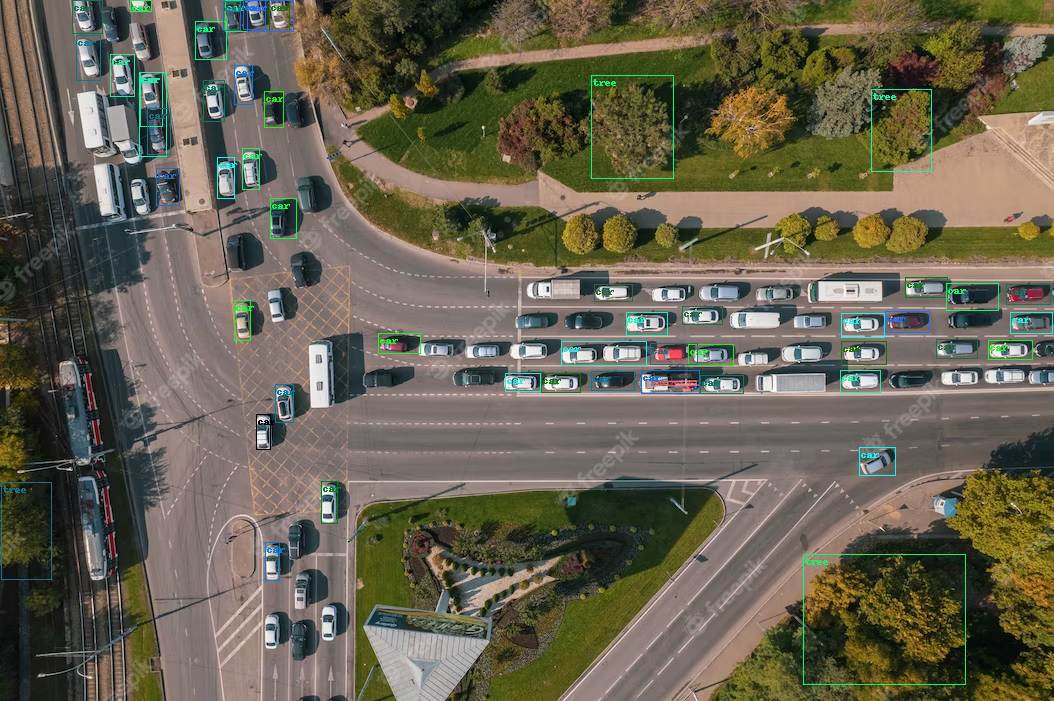

In [ ]:
img = get_inference('/content/img.png', threshold, model1)
img.show()

In [ ]:
torch.save(model.state_dict(), '/content/model.pt')

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model.pt'))
model1.to(device)
model1.eval()